In [31]:
import tensorflow as tf
import keras 
from keras.layers import *
from keras.models import *
import vizdoom 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import deque
from vizdoom import *
import random
import time

In [32]:
num_seq = 4

In [33]:
shape = [128,128,3]

In [34]:
left = [1, 0, 0]
right = [0, 1, 0]
shoot = [0, 0, 1]
possible_actions = [left, right, shoot]
total_episodes = 500
max_steps = 125
batch_size = 128
explore_start = 1.0
explore_stop = 0.01
decay_rate = 1e-4


gamma = 0.95
memory_size = 1e+3

training = False
# change the training to true in order to train your model

episode_render = False



In [35]:
game = DoomGame()

In [36]:
game.load_config("basic.cfg")

True

In [37]:
game.set_doom_scenario_path("basic.wad")

In [38]:
game.init()

In [39]:
arr = np.array(game.get_state().screen_buffer)

In [40]:
arr.shape

(3, 240, 320)

In [41]:
x = np.stack([arr[i] for i in range(3)], axis=2)

In [42]:
x.shape

(240, 320, 3)

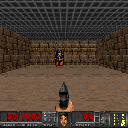

In [43]:
Image.fromarray(x).resize([128,128])

In [44]:
[1, *[1,2]]

[1, 1, 2]

In [45]:
class NeuralNetwork:
    
    def __init__(self, shape):
        self.input_ = tf.placeholder(shape = [None, *shape], dtype=tf.float32)
        self.actions_ = tf.placeholder(shape=[None, 3], dtype=tf.float32)
        self.target_Q = tf.placeholder(shape=[None], dtype=tf.float32)
        self.conv1 = tf.layers.conv2d(self.input_, 32,
                                      kernel_size=(5,5), strides=(2,2),
                                      padding="SAME", activation=None, name="conv1",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        self.batch_norm1 = tf.layers.batch_normalization(self.conv1, training=True, name="ba1")
        self.conv1_out = tf.nn.elu(self.batch_norm1, name="out1")
        
        
        self.conv2 = tf.layers.conv2d(self.conv1_out, 64, [5,5],
                                      strides=(2,2), padding="SAME", activation=None, name="conv2",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        self.batch_norm2 = tf.layers.batch_normalization(self.conv2, training=True, name="ba2")
        self.conv2_out = tf.nn.elu(self.batch_norm2, name = "out2")
        
        self.conv3 = tf.layers.conv2d(self.conv2_out, 128, [5,5], [2,2], activation=None, name="conv3", padding="SAME",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        self.batch_norm3 = tf.layers.batch_normalization(self.conv3, training=True, name="ba3")
        self.conv3_out = tf.nn.elu(self.batch_norm3, name="out3")
        
        
        self.conv4 = tf.layers.conv2d(self.conv3_out, 128, [5,5], [2,2], activation=None, name="conv4", padding="SAME",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        self.batch_norm4 = tf.layers.batch_normalization(self.conv4, training=True, name="ba4")
        self.conv4_out = tf.nn.elu(self.batch_norm4, name="out4")
        
        
        self.flat = tf.layers.flatten(self.conv4_out)
        
        self.fc1 = tf.layers.dense(self.flat, 1000, activation=tf.nn.relu, name="fc1",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        self.fc2 = tf.layers.dense(self.fc1, 100, activation=tf.nn.relu, name="fc2",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        self.out = tf.layers.dense(self.fc2, 3, activation=None, name="fc3",
                                      kernel_initializer= tf.glorot_uniform_initializer(dtype=tf.float16))
        
        
        
        
        self.Q = tf.reduce_sum(tf.multiply(self.out, self.actions_), axis=1)
        
        self.loss = tf.reduce_mean(tf.square(self.Q - self.target_Q))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=2e-4).minimize(self.loss)
        
        
        
        
        
        
        
        
        
        
        
    
    

In [46]:
tf.reset_default_graph()
nn = NeuralNetwork([*shape[:-1],shape[-1] * num_seq])

In [47]:
class memory:
    def __init__(self, max_size = int(1e+6)):
        self.mem = []
        self.counter = 0
        self.max_size = max_size
        
    def addMem(self, x):
        if self.counter >= self.max_size :
            self.mem[int(int(self.counter)%int(self.max_size))] = x
        else:
            self.mem.append(x)
        self.counter += 1
    
    def getMem(self, batch_size):
        ind = np.arange(len(self.mem))
        ind = np.random.choice(ind, batch_size, replace=False)
        return [self.mem[i] for i in ind]
        
    
    

In [48]:
def get_picture(game, before = None, arr = None):
    if arr is None:
        arr = game.get_state().screen_buffer
        x = np.stack([arr[i] for i in range(3)], axis=2)
        x = np.array(Image.fromarray(x).resize(shape[:-1])).astype(np.float32)
    else : 
        x = arr.astype(np.float32)
    x = x / 255.0
    if before is None:
        return np.concatenate([x for i in range(num_seq)], axis=-1)
    
    else :
        res = before.copy()
        res [:,:,:-3] = before[:,:,3:]
        res[:,:,-3:]=x
        return res
    
    

In [49]:
mem = memory(memory_size)

In [50]:
for i in range(int(batch_size)):
    if i == 0 :
        state = get_picture(game)
    ac = random.choice(possible_actions)
    reward = game.make_action(ac)
    done = game.is_episode_finished()
    if done :
        next_state = get_picture(game, state, np.zeros([*state.shape[:-1],3]))
        mem.addMem((state, ac, next_state, reward, done))
        game.new_episode()
        state = get_picture(game)
        
    else:
        next_state = get_picture(game, state)
        mem.addMem((state, ac, next_state, reward, done))
        state = next_state
#     if i % 1000 == 0 :
#         print(sys.getsizeof(mem.mem))

In [51]:
def predict_next(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    
    rand = np.random.rand()
    
    
    explore_prob = explore_stop + (explore_start - explore_stop) * np.exp(-decay_step * decay_rate)
    
    
    if explore_prob > rand :
        
        action = random.choice(possible_actions)
        
    else : 
        Qs = sess.run(nn.out, feed_dict={nn.input_:state})
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
    return action, explore_prob
    

In [52]:
saver = tf.train.Saver()

In [53]:
if training == True :
    with tf.Session() as sess :
        sess.run(tf.global_variables_initializer())
        
        decay_step = 0
        
        game.init()
        
        
        for episode in range(total_episodes):
            
            step = 0
            
            episode_reward = []
            game.new_episode()
            
            state = get_picture(game)
            st = 0
            
            while step < max_steps :
                
                step += 1 
                decay_step += 1
                st += 1
                
                action, explore_prob = predict_next(explore_start, explore_stop, decay_rate, 
                                                    decay_step, state.reshape((1,)+state.shape), possible_actions)
                
                reward = game.make_action(action)
                
                done = game.is_episode_finished()
                
                episode_reward.append(reward)
                
                
                if done : 
                    next_state = get_picture(game, state, np.zeros(shape))
                    #the next line is instead of a break
                    step = max_steps
                    mem.addMem((state, action, next_state, reward, done))
                    
                    
                    
                    
                else :
                    
                    next_state = get_picture(game, state)
                    mem.addMem((state, action, next_state, reward, done))
                    state = next_state
                
                
                batch = mem.getMem(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[3] for each in batch]) 
                next_states_mb = np.array([each[2] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])
                
                
#                 print(np.sum(np.isnan(next_states_mb)))
                Qs_next_state = sess.run(nn.out, feed_dict={nn.input_:next_states_mb})
#                 print(Qs_next_state)
#                 print()
                
                target_Qs_batch = []
                
                for i in range(batch_size):
                    
                    t = dones_mb[i]
                    
                    
                    if t : 
                        target_Qs_batch.append(rewards_mb[i])
                    else :
                        target = rewards_mb[i] + gamma*np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                
                target_Qs_batch = np.array(target_Qs_batch)
                feed_dict = {nn.input_:states_mb, nn.target_Q:target_Qs_batch, nn.actions_:actions_mb}
                sess.run(nn.optimizer, feed_dict)
                
            
            loss = nn.loss.eval(session=sess, feed_dict=feed_dict)
            print(episode, explore_prob, np.sum(episode_reward),st, loss)
            
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")
                
                
                
                
            
        
        
    

In [ ]:
if training == False :
    game.init()
    with tf.Session() as sess :
        saver.restore(sess, "./models/model.ckpt")
        for episode in range(total_episodes):
            game.new_episode()
            state = get_picture(game)
            rewards = 0
            for i in range(max_steps):
                time.sleep(0.8e-2)
                next_action = np.argmax(sess.run(nn.out, feed_dict={nn.input_:state.reshape((1,)+state.shape) }))
                rewards += game.make_action(possible_actions[next_action])
                done = game.is_episode_finished()
                if done :
                    if episode % 20 == 0:
                        print(rewards)
                else :
                    state = get_picture(game, state)


INFO:tensorflow:Restoring parameters from ./models/model.ckpt
